In [3]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_validate
from scipy.stats import ttest_ind


In [16]:
def read_csv(filename):
    with open(filename, newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        return list(reader)

data = read_csv("D:\\visua stiudio xanh\\hocki_3\\laptirnh_py\\K215480106043_NguyenVanSong_BaiTap-KhoaHocDuLieu_21-4\\bai1\\titanic\\train.csv")


In [19]:
rows = []
for row in data:
    try:
        pclass = int(row['Pclass'])
        sex = 1 if row['Sex'] == 'male' else 0
        age = float(row['Age']) if row['Age'] else np.nan
        sibsp = int(row['SibSp'])
        parch = int(row['Parch'])
        fare = float(row['Fare']) if row['Fare'] else 0.0
        embarked = row['Embarked'] if row['Embarked'] else 'U'
        cabin = row['Cabin']
        name = row['Name']
        survived = int(row['Survived'])
        rows.append([survived, pclass, sex, age, sibsp, parch, fare, embarked, cabin, name])
    except:
        continue

data_np = np.array(rows, dtype=object)


In [20]:
survived, pclass, sex, age, sibsp, parch, fare, embarked, cabin, name = data_np.T

mask_known_age = ~np.isnan(age.astype(float))
X_age = np.vstack((pclass[mask_known_age].astype(int), 
                   sex[mask_known_age].astype(int), 
                   sibsp[mask_known_age].astype(int), 
                   parch[mask_known_age].astype(int))).T
y_age = age[mask_known_age].astype(float)

lr = LinearRegression()
lr.fit(X_age, y_age)

mask_missing_age = np.isnan(age.astype(float))
X_missing = np.vstack((pclass[mask_missing_age].astype(int), 
                       sex[mask_missing_age].astype(int), 
                       sibsp[mask_missing_age].astype(int), 
                       parch[mask_missing_age].astype(int))).T
predicted_age = lr.predict(X_missing)
age[mask_missing_age] = predicted_age


In [21]:
le_embarked = LabelEncoder()
embarked_encoded = le_embarked.fit_transform(embarked)

X_emb = np.vstack((pclass.astype(int), fare.astype(float), age.astype(float), embarked_encoded)).T
imputer = KNNImputer(n_neighbors=3)
X_emb_imputed = imputer.fit_transform(X_emb)
embarked_filled = le_embarked.inverse_transform(np.round(X_emb_imputed[:, -1]).astype(int))


In [22]:
deck = np.array([c[0] if c else 'U' for c in cabin])
le_deck = LabelEncoder()
deck_encoded = le_deck.fit_transform(deck)


In [23]:
sibsp = sibsp.astype(int)
parch = parch.astype(int)
family_size = sibsp + parch + 1
is_alone = (family_size == 1).astype(int)


In [26]:
def extract_title(name):
    match = re.search(r',\s*([^\.]*)\.', name)
    if match:
        return match.group(1).strip()
    return 'None'

titles = [extract_title(n) for n in name]
common_titles = {'Mr', 'Miss', 'Mrs', 'Master'}
titles_cleaned = [t if t in common_titles else 'Rare' for t in titles]
le_title = LabelEncoder()
title_encoded = le_title.fit_transform(titles_cleaned)


In [24]:
fare = fare.astype(float)
fare_per_person = fare / family_size


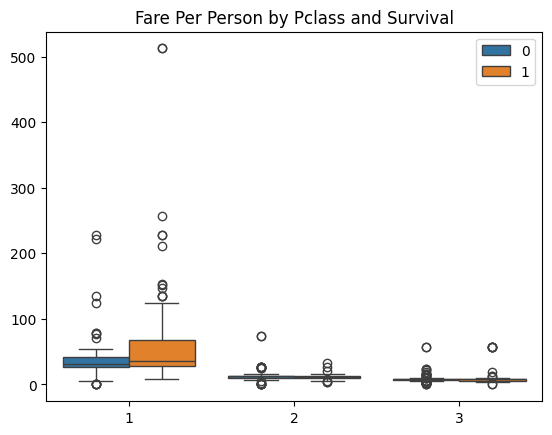

T-test: t = -5.6683, p = 0.0000


In [27]:
pclass_int = pclass.astype(int)
survived_int = survived.astype(int)

sns.boxplot(x=pclass_int, y=fare_per_person, hue=survived_int)
plt.title("Fare Per Person by Pclass and Survival")
plt.show()

group_0 = fare_per_person[survived_int == 0]
group_1 = fare_per_person[survived_int == 1]
t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)
print(f"T-test: t = {t_stat:.4f}, p = {p_val:.4f}")


In [28]:
X = np.column_stack([
    pclass.astype(int), sex.astype(int), age.astype(float),
    fare_per_person, le_embarked.transform(embarked_filled),
    deck_encoded, title_encoded, family_size, is_alone
])
y = survived.astype(int)

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', RandomForestClassifier(random_state=42))
])

params = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [5, 10, None]
}

grid = GridSearchCV(pipe, params, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X, y)

print("Best Params:", grid.best_params_)


Best Params: {'model__max_depth': 5, 'model__n_estimators': 100}


In [29]:
scores = cross_validate(grid.best_estimator_, X, y, cv=5,
                        scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

for metric, value in scores.items():
    print(f"{metric}: {np.mean(value):.4f}")


fit_time: 0.1662
score_time: 0.0220
test_accuracy: 0.8305
test_precision: 0.8270
test_recall: 0.7073
test_f1: 0.7606
test_roc_auc: 0.8783


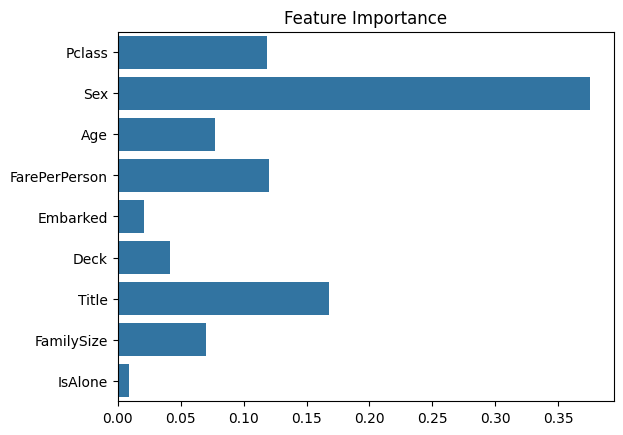

In [30]:
model = grid.best_estimator_.named_steps['model']
features = ['Pclass', 'Sex', 'Age', 'FarePerPerson', 'Embarked', 'Deck', 'Title', 'FamilySize', 'IsAlone']
importances = model.feature_importances_

sns.barplot(x=importances, y=features)
plt.title("Feature Importance")
plt.show()
